In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# helper funcitons
# first we define functions we need
# haversine distance function
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# find the nmber of nearest infrastructure to our property listing
# km is the maximum distance we want to calculate from. 
# calculate the number of infrastructure within x km
def count_nearest(lat, long, infrastructure, km):
    distances = infrastructure.apply(
        lambda row: haversine(lat, long, row['lat'], row['lng']), 
        axis=1)
    
    return sum(i <= km for i in distances)


# find the distance of the nearest infrastructure to our property listing
def find_nearest_distance(lat, long, infrastructure):
    distances = infrastructure.apply(
        lambda row: haversine(lat, long, row['lat'], row['lng']), 
        axis=1)
    return distances.min()


# get the population of the subzone the listing is in
def find_subzone_population(subzone, subzones_df):
    sz = subzones_df
    if subzone == "":
        sz_pop = None
    else:
        sz_pop = sz.loc[sz['name'] == subzone, 'population'].item()
    return sz_pop

# get the population density of the subzone the listing is in
def find_subzone_population_density(subzone, subzones_df):
    sz = subzones_df
    if subzone == "":
        sz_pop_density = None
    else:
        sz_pop_density = sz.loc[sz['name'] == subzone, 'population'].item()/sz.loc[sz['name'] == subzone, 'area_size'].item()
    return sz_pop_density

def improve_dataset(df):
    df = df.copy()
    # get the files containing the infrastructures data
    cc = pd.read_csv("data/auxiliary-data/sg-commerical-centres.csv")
    mrt = pd.read_csv("data/auxiliary-data/sg-mrt-stations.csv")
    ps = pd.read_csv("data/auxiliary-data/sg-primary-schools.csv")
    ss = pd.read_csv("data/auxiliary-data/sg-secondary-schools.csv")
    sm = pd.read_csv("data/auxiliary-data/sg-shopping-malls.csv")
    sz = pd.read_csv("data/auxiliary-data/sg-subzones.csv")
    
    df.subzone = df.subzone.fillna('') 
    
    # get the population of the subzone the listing is in, and add to data
    df['subzone_pop'] = df.apply(
        lambda row: find_subzone_population(row['subzone'], sz), 
        axis=1)
    df['subzone_pop'] = df['subzone_pop'].round(decimals=3)
    
    # get the population of the subzone the listing is in, and add to data
    df['subzone_pop_density'] = df.apply(
        lambda row: find_subzone_population(row['subzone'], sz), 
        axis=1)
    df['subzone_pop_density'] = df['subzone_pop_density'].round(decimals=3)
    
    # calculate distance to nearest commercial center
    df['dist_2_nearest_cc'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], cc), 
        axis=1)
    df['dist_2_nearest_cc'] = df['dist_2_nearest_cc'].round(decimals=3)

    # calculate the number of commercial centers within x km
    df['nearest_cc_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], cc, 1), 
        axis=1)
    
    # calculate distance to nearest mrt station
    df['dist_2_nearest_mrt'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], mrt), 
        axis=1)
    df['dist_2_nearest_mrt'] = df['dist_2_nearest_mrt'].round(decimals=3)

    # calculate the number of mrt stations within x km
    df['nearest_mrt_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], mrt, 1), 
        axis=1)
    
    # calculate distance to nearest primary school
    df['dist_2_nearest_ps'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], ps), 
        axis=1)
    df['dist_2_nearest_ps'] = df['dist_2_nearest_ps'].round(decimals=3)

    # calculate the number of primary schools within x km
    df['nearest_ps_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], ps, 1), 
        axis=1)
    # calculate distance to nearest secondary school
    df['dist_2_nearest_ss'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], ss), 
        axis=1)
    df['dist_2_nearest_ss'] = df['dist_2_nearest_ss'].round(decimals=3)

    # calculate the number of secondary schools within x km
    df['nearest_ss_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], ss, 1), 
        axis=1)
    
    # calculate distance to nearest shopping mall
    df['dist_2_nearest_sm'] = df.apply(
        lambda row: find_nearest_distance(row['lat'], row['lng'], sm), 
        axis=1)
    df['dist_2_nearest_sm'] = df['dist_2_nearest_sm'].round(decimals=3)

    # calculate the number of secondary schools within x km
    df['nearest_sm_count'] = df.apply(
        lambda row: count_nearest(row['lat'], row['lng'], sm, 1), 
        axis=1)

    return df

In [3]:
def visualize():
    pass

# IMPORTANT: Trivial modifications only. Do not aggregate/standardize/impute here!!

def ignore_attributes(df) -> pd.DataFrame:
    # Drop listing id; nominal identifier with no meaning
    df.drop('listing_id', axis=1, inplace=True)

    # Drop elevation; all the values are 0, spurious attribute
    df.drop('elevation', axis=1, inplace=True)

    # Drop url; nominal identifier with no meaning; useful for manual lookups or scraping
    df.drop('property_details_url', axis=1, inplace=True)

    # Drop floor level as 83% missing and sparse with the rest of the values. 
    # Not enough data available to get the model trained.
    df.drop('floor_level', axis=1, inplace=True)

    # Drop column property_type, tenure and furnishing as it is now encoded
    df.drop('property_type',axis = 1, inplace=True)
    df.drop('tenure',axis=1, inplace=True)
    df.drop('furnishing', axis=1, inplace=True)

    # BELOW CODE IN THIS SECTION IS ONLY MEANT TO GET THE SKELETON WORKING; RE-EVALUATE EACH ATTRIBUTE ONE BY ONE
    df.drop('title', axis=1, inplace=True)
    df.drop('address', axis=1, inplace=True)
    df.drop('property_name', axis=1, inplace=True)
    df.drop('built_year', axis=1, inplace=True)
    df.drop('available_unit_types', axis=1, inplace=True)
    df.drop('total_num_units', axis=1, inplace=True) # Bernard verified dropping it. 27.9% missing.
    df.drop('lat', axis=1, inplace=True)
    df.drop('lng', axis=1, inplace=True)
    #df.drop('subzone', axis=1, inplace=True)
    df.drop('planning_area', axis=1, inplace=True)

    return df

def handle_missing_values(df) -> pd.DataFrame:
    # Treat missing year data as new.
    # Semantically, we define this attribute as the depreciation factor for pricing.
    # A new house or one with missing data denotes the depreciation factor is 0 or unknown.
    # The depreciation factor is assumed to be the difference between construction and current year.
    # TODO: Maybe do not treat future years as current! Inflation factor might be one to look out for.
    df['built_year'] = df['built_year'].fillna(2022)
    
    # TODO: 80 are missing. Should we remove them or should we keep it as 0?
    # Verify assumption if studio qualifies as 1 bed. 
    # 75 of missing are studio, we replace the Nan as 1
    filter_beds_studio = ((df.num_beds.isna()) & ((df.title.str.contains('studio','Studio', flags=re.IGNORECASE, regex=True))))
    df.loc[filter_beds_studio, "num_beds"] = 1
    # 5 of missing, we do not have much info. Use 0 to denote absence of attribute
    df['num_beds'] = df['num_beds'].fillna(0)

    # TODO: 400 are missing. Cannot remove so many data. Use 0 to denote absence of attribute.
    df['num_baths'] = df['num_baths'].fillna(0)
    
    
    return df
    
def handle_invalid_values(df) -> pd.DataFrame:
    # Price is the target regression variable. If negative or 0, treat that row as invalid.
    if 'price' in df:
        df = df[df.price > 0]

    # TODO: Verify the steps below for HDB - bed/bath ratio, price checks
    # Filtering those with number of bathrooms more than number of bedrooms for HDB
    filter_bath_beds_hdb = ((df.num_baths > df.num_beds) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
    df = df.drop(df[filter_bath_beds_hdb].index)

    #Filtering those with number of bathrooms more than 4, number of bedrooms more than 4 for HDB
    filter_bath_beds_4_hdb = (((df.num_baths > 4) | (df.num_beds > 5)) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
    df = df.drop(df[filter_bath_beds_4_hdb].index)
    
    # price ; filtering for HDB price more than 2 million
    if 'price' in df:
        filter_price_hdb = ((df.price > 2000000) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
        df = df.drop(df[filter_price_hdb].index)
        
    ## Outliers
    
    # Filtering those hdb with more than 2000 size_sqft
    filter_size_hdb = ((df.size_sqft > 2000) & ((df.property_type.str.contains('hdb','Hdb', flags=re.IGNORECASE, regex=True)) | (df.title.str.contains('hdb','Hdb', regex=False))))
    df[filter_size_hdb][['property_type','num_baths','num_beds','size_sqft','price']]
    df = df.drop(df[filter_size_hdb].index)
    
    
    if 'price' in df:
    # Filtering those data with less than $200/square feet
        df['price per sq ft'] = df['price']/df['size_sqft']
        filter_price_sqft_200 = ((df['price per sq ft'] < 200) & (df['price per sq ft'] > 0))
        df = df.drop(df[filter_price_sqft_200].index)
    # Filtering those data with less than 500 square feet, and more than $5000 per square feet
        df['price per sq ft'] = df['price']/df['size_sqft']
        filter_size = ((df['price per sq ft'] > 5000) & (df['price per sq ft'] > 0) & (df['size_sqft'] < 500))
        df = df.drop(df[filter_size].index)
        
    df.drop('price per sq ft', axis=1, inplace=True)
        
    return df

def transform_data(df) -> pd.DataFrame:
    # TODO: Test against not doing this.
    df.loc[df["built_year"] > 2022, "built_year"] = 2022
    
    # Convert built_year into the aforementioned depreciation factor
    df["depreciation"] = (2022-df["built_year"])
    
    # TODO: Add details on why we are doing so
    df.loc[df.property_type.str.contains('hdb', flags=re.IGNORECASE, regex=True), 'property_type'] = 'hdb'
    df.loc[df.property_type.str.contains('condo', flags=re.IGNORECASE, regex=True), 'property_type'] = 'condo'
    df['property_type'] = df['property_type'].str.lower()
    df.loc[df.property_type.str.contains('cluster house', flags=re.IGNORECASE, regex=True), 'property_type'] = 'landed'
    df.loc[df.property_type.str.contains('townhouse', flags=re.IGNORECASE, regex=True), 'property_type'] = 'landed'
    df.loc[df.property_type.str.contains('land only', flags=re.IGNORECASE, regex=True), 'property_type'] = 'landed'
    df.loc[df.property_type.str.contains('apartment',  flags=re.IGNORECASE, regex=True), 'property_type'] = 'condo'
    df.loc[df.property_type.str.contains('bungalow', flags=re.IGNORECASE, regex=True), 'property_type'] = 'bungalow'
    df.loc[df.property_type.str.contains('semi-detached house', flags=re.IGNORECASE, regex=True), 'property_type'] = 'corner'
    df.loc[df.property_type.str.contains('corner terrace',flags=re.IGNORECASE, regex=True), 'property_type'] = 'corner'
    df.loc[df.property_type.str.contains('shophouse', flags=re.IGNORECASE, regex=True), 'property_type'] = 'protected'
    df.loc[df.property_type.str.contains('conservation house', flags=re.IGNORECASE, regex=True), 'property_type'] = 'protected'
    
    # Get one hot encoding of columns property_type
    property_columns = ['bungalow', 'condo', 'hdb', 'corner', 'landed', 'protected', 'terraced house', 'walk-up']
    one_hot = pd.get_dummies(df['property_type'], columns=property_columns)
    # Join the encoded df
    df = df.join(one_hot)
    
    df['tenure'] = df['tenure'].fillna(value=df.property_type)
    df.loc[df.tenure.str.contains('hdb', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('condo', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('terraced house', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('corner', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('landed', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('protected', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('bungalow', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'

    df.loc[df.tenure.str.contains('110-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('103-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('102-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'
    df.loc[df.tenure.str.contains('100-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = '99-year leasehold'

    df.loc[df.tenure.str.contains('999-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('946-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('956-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('947-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'
    df.loc[df.tenure.str.contains('929-year leasehold', flags=re.IGNORECASE, regex=True), 'tenure'] = 'freehold'

    df['encoded_tenure'] = 0
    df.loc[df.tenure.str.contains('freehold', flags=re.IGNORECASE, regex=True), 'encoded_tenure'] = 1
    
    df['encoded_furnishing'] = 0
    df.loc[df.furnishing.str.contains('partial', flags=re.IGNORECASE, regex=True), 'encoded_furnishing'] = 0.5
    df.loc[df.furnishing.str.contains('unfurnished', flags=re.IGNORECASE, regex=True), 'encoded_furnishing'] = -1
    df.loc[df.furnishing.str.contains('fully', flags=re.IGNORECASE, regex=True), 'encoded_furnishing'] = 1
    
    return df
    
def pre_process(df, mode='train') -> pd.DataFrame:
    df = handle_missing_values(df)
    if mode=='train': df = handle_invalid_values(df)
    df = transform_data(df)
    df = ignore_attributes(df)
    
    return df

In [4]:
# Read training data
df = pd.read_csv('data/train.csv') 

In [5]:
df = improve_dataset(df)

In [6]:
df = pre_process(df, mode='train')

In [7]:
print(df.shape)
df.head(3)

(20060, 28)


,num_beds,num_baths,size_sqft,subzone,price,subzone_pop,subzone_pop_density,dist_2_nearest_cc,nearest_cc_count,dist_2_nearest_mrt,...,bungalow,condo,corner,hdb,landed,protected,terraced house,walk-up,encoded_tenure,encoded_furnishing
0,3.0,2.0,1115,yishun south,514500.0,42240.0,42240.0,3.339,0,0.574,...,0,0,0,1,0,0,0,0,0,0.0
1,4.0,2.0,1575,serangoon north,995400.0,15940.0,15940.0,2.402,0,1.734,...,0,0,0,1,0,0,0,0,0,0.0
2,4.0,6.0,3070,mountbatten,8485000.0,9980.0,9980.0,2.171,0,1.320,...,0,1,0,0,0,0,0,0,1,0.5


In [8]:
sz = pd.read_csv("data/auxiliary-data/sg-subzones.csv")
print(sz.shape)
sz.head(3)

(331, 4)


,name,area_size,population,planning_area
0,ang mo kio town centre,0.3169,4810,ang mo kio
1,cheng san,0.9557,28070,ang mo kio
2,chong boon,1.0786,26500,ang mo kio


In [9]:
df2 = sz.copy()

In [10]:
def find_price_average(subzone):
    return df[df['subzone'] == subzone]['price'].mean()

In [11]:
df2['price_average'] = df2.apply(
        lambda row: find_price_average(row['name']), 
        axis=1)

In [12]:
df2

,name,area_size,population,planning_area,price_average
0,ang mo kio town centre,0.3169,4810,ang mo kio,1.257518e+06
1,cheng san,0.9557,28070,ang mo kio,6.093131e+05
2,chong boon,1.0786,26500,ang mo kio,1.632010e+06
3,kebun bahru,1.0464,22620,ang mo kio,2.371333e+06
4,sembawang hills,0.8945,6850,ang mo kio,6.005083e+06
...,...,...,...,...,...
326,springleaf,2.2092,4370,yishun,5.002574e+06
327,yishun central,0.4364,2620,yishun,8.116867e+05
328,yishun east,1.7693,60670,yishun,1.186748e+06
329,yishun south,1.3402,42240,yishun,6.719120e+05


### Population in a Subzone Vs Average Property Price in the Subzone

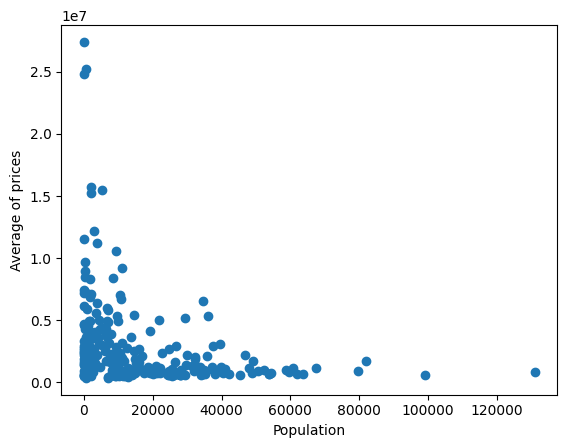

In [13]:
# plot of population against average price in the subzone
xpoints = df2["population"]
ypoints = df2["price_average"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Population')
plt.ylabel('Average of prices')
plt.show()

* It can be concluded from the above plot that the price of housing in highly populated areas are relatively higher than those in less populated areas. There are of course some outliers where the price is quite high in less populated areas, and vice versa.
* Also, it can be concluded that people tend to buy houses in highly populated areas. Maybe due to a need for community and socializing. 

### Population Distribution Across Subzones

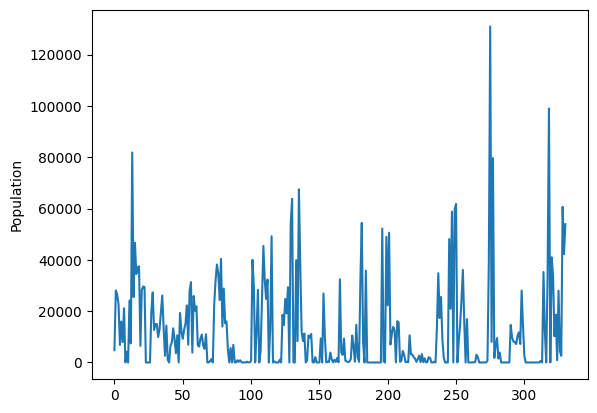

In [14]:
plt.ylabel('Population')
plt.plot(df2["population"])

The population distribution across the Island is interesting. Some subzones have very high population while others have relatively little population. I would believe the highly populated regions are the older subzones of Singapore. The goal would be to have similar population across subzones having similar land areas. 

### Price Distribution Across Subzones

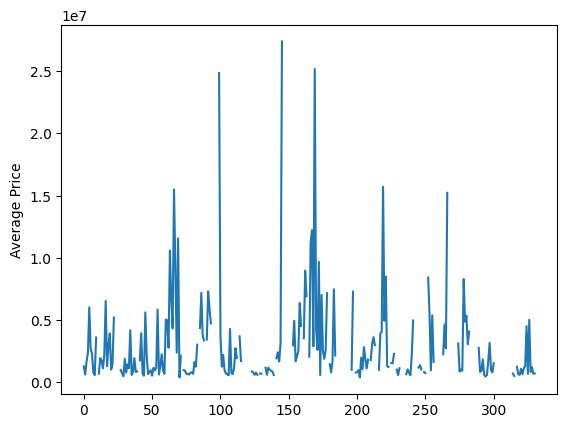

In [15]:
plt.ylabel('Average Price')
plt.plot(df2["price_average"])

The population price across the Island is interesting. Some subzones have very high prices while others have relatively little population. 

### Population in a Subzone Vs Area of the Subzone

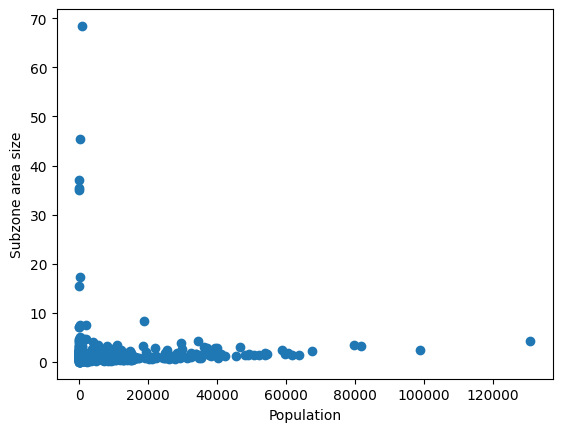

In [16]:
# plot of population against average price in the subzone
xpoints = df2["population"]
ypoints = df2["area_size"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Population')
plt.ylabel('Subzone area size')
plt.show()

Subzones with larger land areas have fewer populations. As concluded earlier, the goal would be to have similar population across subzones having similar land areas.

### Property Price Vs Population of the Subzone The Property is Located In 

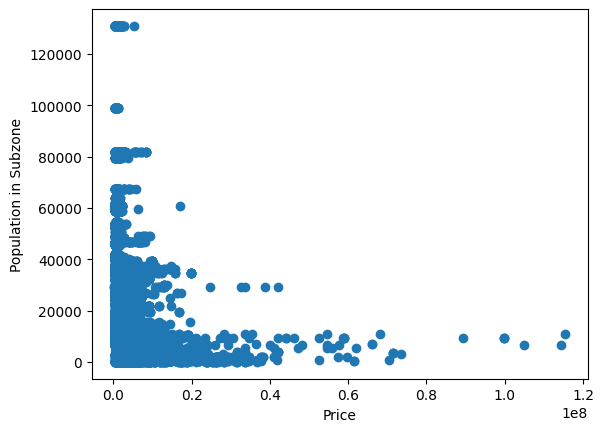

In [27]:
xpoints = df["price"]
ypoints = df["subzone_pop"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Population in Subzone')
plt.show()

Similar distribution as the plot of Avg. Price in Subzone vs Population in Subzone. However, it is noticeable that there are very few listed properties in subzones with population equaling or greater than 80000. This might be because these areas are already highly populated. There might be a need to move people from highly populated areas to to less populated areas, as even non-expensive properties are also present in less populated areas. 

Also, properties in highly populated areas cost less than SGD (0.2 X 1e8).

### plots of distance to nearest (within 1km) infrastructure against price of property

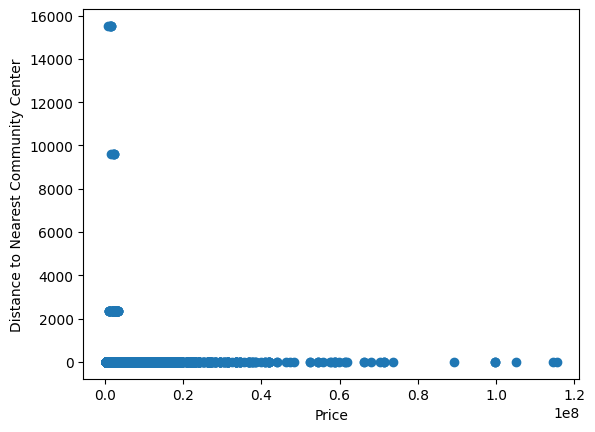

In [20]:
xpoints = df["price"]
ypoints = df["dist_2_nearest_cc"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Distance to Nearest Community Center')
plt.show()

As expected, most housing with low price also have relatively low distance to the nearest community center, although there are exceptions. Also, there are some houses that are very far to community centers but have low prices also. It seems disrance to the price of a property is really not dependent on the nearest community center.

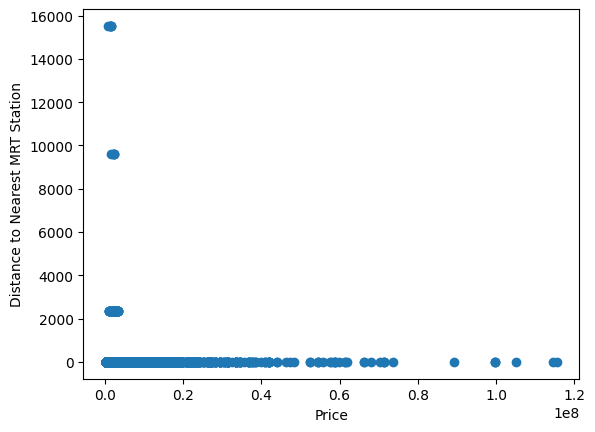

In [21]:
xpoints = df["price"]
ypoints = df["dist_2_nearest_mrt"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Distance to Nearest MRT Station')
plt.show()

Same result as above.

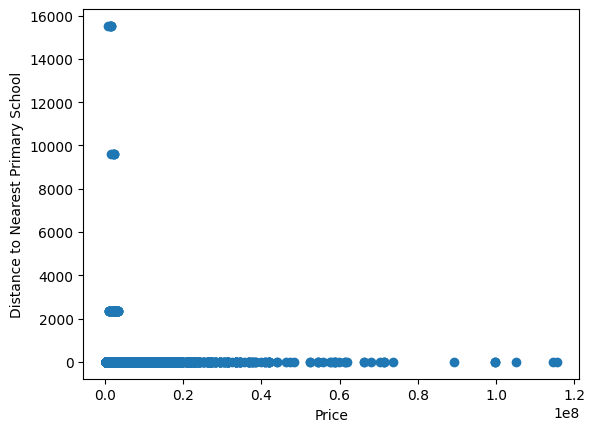

In [22]:
xpoints = df["price"]
ypoints = df["dist_2_nearest_ps"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Distance to Nearest Primary School')
plt.show()

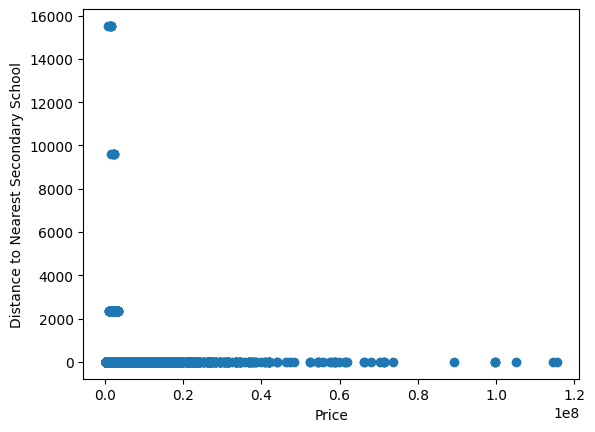

In [23]:
xpoints = df["price"]
ypoints = df["dist_2_nearest_ss"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Distance to Nearest Secondary School')
plt.show()

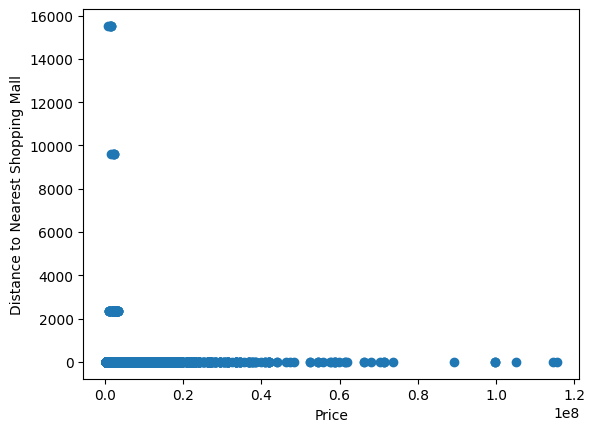

In [24]:
xpoints = df["price"]
ypoints = df["dist_2_nearest_sm"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Distance to Nearest Shopping Mall')
plt.show()

There are no differences among these plots of Price Vs Distance to nearest Infrastruccture. This insight might make us conclude that people in Singapore do not really care about how close the nearest infrastructure is to their homes. While this is peculiar and interesting about Singapore and its inhabitants, the resaon might be because:
1. Singapore is a small island, hence making the whole of it accessible in a rather short amount of time from anywhere within it if you have a personal vehicle, thus making the location of public infrastructures almost irrelevant to you.
2. The public transport is system in Singapore is affordable and spans the whole Island. This also alleviates the need to be close to a public infrastructure, since it would be reachable in little or no time with public transport. In fact most people in Singapore prefer not to own personal vehicles because of this, aside from affordability issues. 
3. Public infrastructures in Singapore are relatively evenly located. This means all planning areas/subzones usually have infrastructures like MRT, Primary School, Secondary, School, etc. 

### plots of nearest infrastructure count against property price

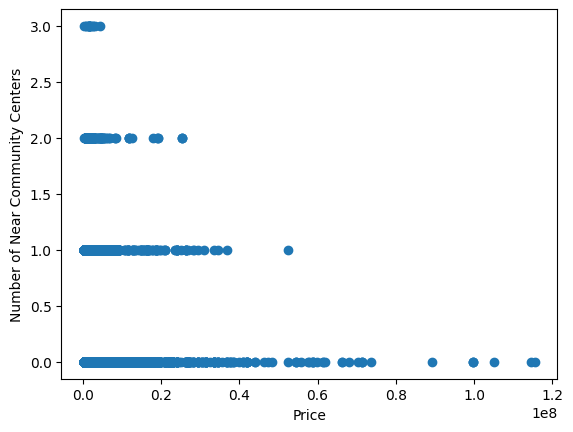

In [28]:
xpoints = df["price"]
ypoints = df["nearest_cc_count"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Number of Near Community Centers')
plt.show()

Most housing has zero community centers near them. However, the ones that do have community centers near are relatively lower in price. All housing above SGD (0.6 X 1e8)  have zero community centers near them, which shows some effect on the prices. Houses costing less than SGD (0.4 X 1e8)  have 2 or more community centers near them. 

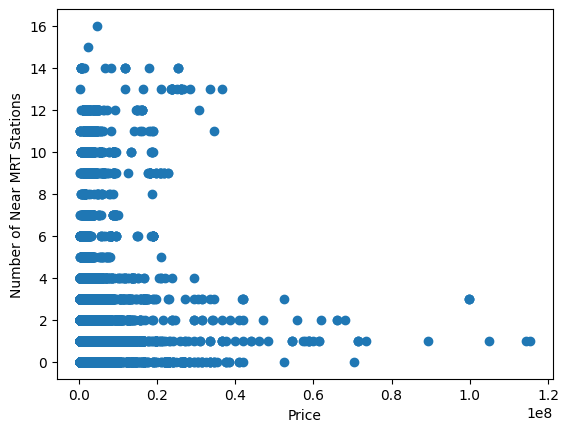

In [33]:
xpoints = df["price"]
ypoints = df["nearest_mrt_count"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Number of Near MRT Stations')
plt.show()

Properties with no MRT station near them cost less than SGD(0.8 X 1e8), while properties with 1 MRT cost even as much as the maximum price in the dataset. This is an interesting insight. Hoever properties with 3 MRT stations or more cost less than SGD(0.6 X 1e8).

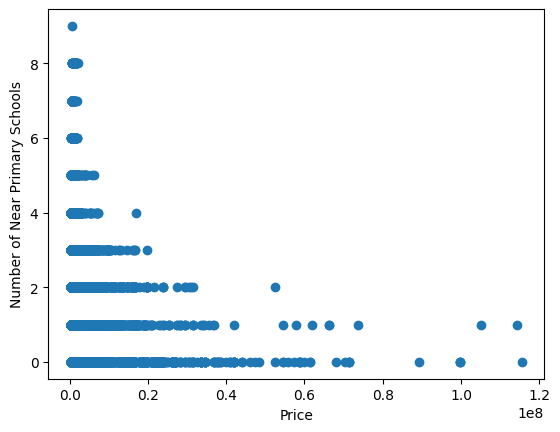

In [34]:
xpoints = df["price"]
ypoints = df["nearest_ps_count"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Number of Near Primary Schools')
plt.show()

Properties with yero primary schools are represented a lot in our data. This may mean people with no children or commercial properties. However, properting with 4 primary schools or more cost less than SGD(0.4 X 1e8) with an exception. Schools with 1 primary school have a range ofprices from lowest price to highest price represented in our data. 

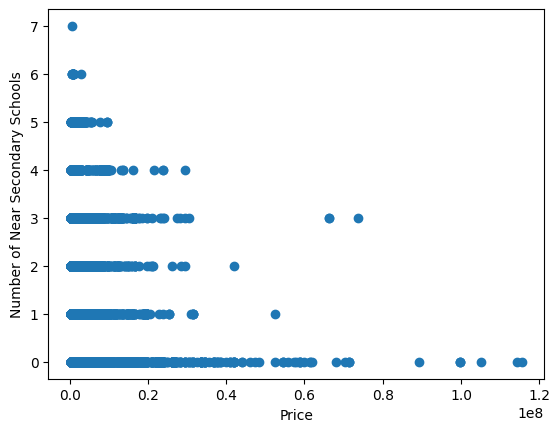

In [35]:
xpoints = df["price"]
ypoints = df["nearest_ss_count"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Number of Near Secondary Schools')
plt.show()

The higher the number of secondary schools near a property, the lower the price. Properties with zero secondary schools are represented a lot in our data. This may mean people with no children or commercial properties. Properties with one secondary school or more cost less than SGD(0.4 X 1e8) with only 5 exceptions. 

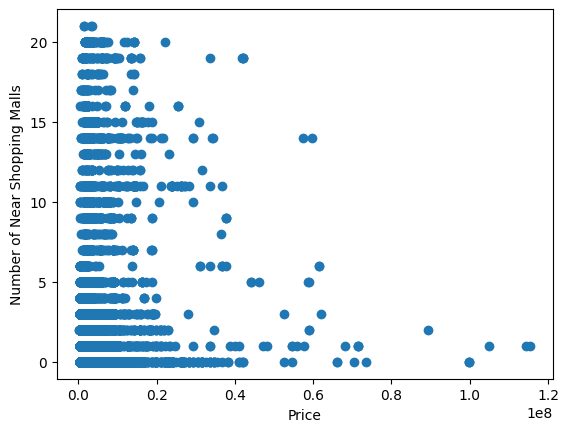

In [36]:
xpoints = df["price"]
ypoints = df["nearest_sm_count"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Number of Near Shopping Malls')
plt.show()

Just like the previous infrastructures, there are properties with zero shopping malls near them and the reasin/insight for this is already explained above. However, an even more interesting fact here is the amount of shopping malls in Singapore are a lot. And the price of properties is less than SGD(0.8 X 1e8) for propeties having 1 shopping mall or more near them with only 3 outliers for 1 shopping mall and 1 outlier for 2 shopping malls. 

### Price vs Depreciation

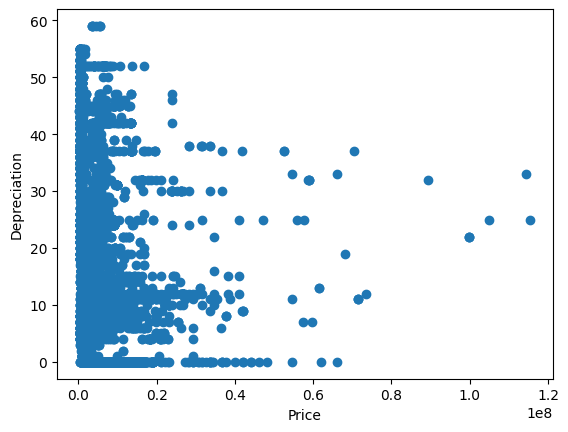

In [37]:
xpoints = df["price"]
ypoints = df["depreciation"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Depreciation')
plt.show()

More properties are represented where depreciation is less than 50 and the price is below SGD(0.8 X 1e8). Highly deprecited (more than 50) properties are few and cost very low, i.e., less than SGD(0.2 X 1e8).

### Number of beds/baths vs Price

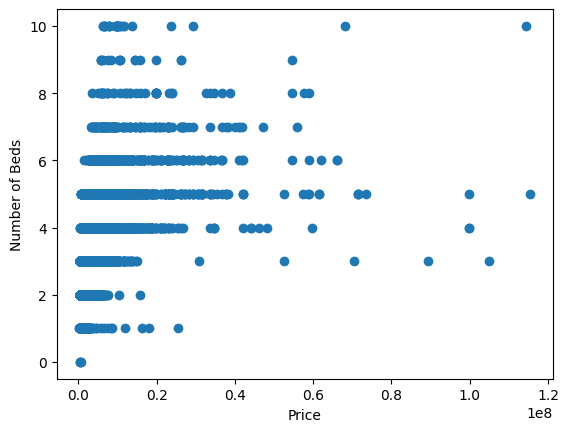

In [40]:
xpoints = df["price"]
ypoints = df["num_beds"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Number of Beds')
plt.show()

Some properties with the same number of beds cost higher while the others with same number of beds cost lower. This might be due to the different kinds of properties in Singapore, i.e. Condos, HDBs, etc. However, properties with only 2 beds or less cost less than SGD(0.2 X 1e8) with only one outlier, which is also very close to the cost. This is largely expected. 

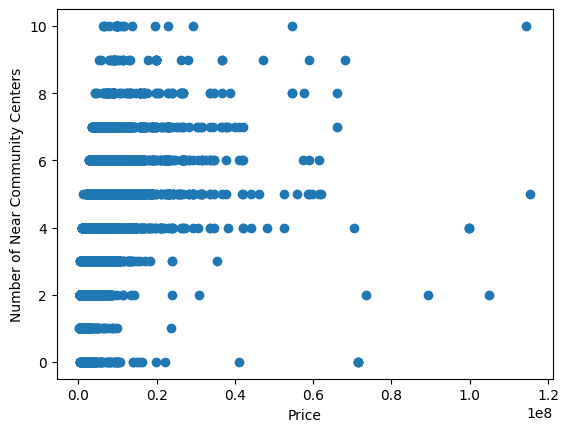

In [47]:
xpoints = df["price"]
ypoints = df["num_baths"]

plt.plot(xpoints, ypoints, 'o')
plt.xlabel('Price')
plt.ylabel('Number of Near Community Centers')
plt.show()

Very similar to number of beds

### THANK YOU